<a href="https://colab.research.google.com/github/pavanreddy565/Transformers-Learning/blob/main/self_attention_for_transormers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import math

L,d_k,d_v=4,8,8
q=np.random.randn(L,d_k)
k=np.random.randn(L,d_k)
v=np.random.randn(L,d_v)


In [ ]:
q

array([[-0.55529341,  0.20801185,  0.48577656,  2.1881768 , -0.26374108,
         1.59504315,  0.23573583, -0.85210244],
       [-0.01811159,  0.04202485,  0.54153039, -1.30765806,  1.78445057,
        -2.19189673,  0.209653  ,  0.77968591],
       [-2.42105907, -1.23433993,  0.8028707 , -1.33911154,  0.60130762,
         1.06235956,  0.48569766,  1.81284844],
       [ 1.11411019, -0.20213641, -0.41712935,  0.26820755, -0.28561422,
         0.78973933, -0.70866584,  0.20285712]])

# self attention
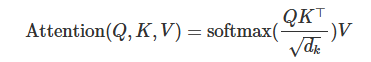

In [ ]:
np.matmul(q,k.T)

array([[-6.00950821, -7.13867621,  2.62498396,  2.18935233],
       [ 6.26219276,  3.61683769, -2.19612009,  1.57789395],
       [ 5.2884317 , -0.39010729, -6.10039095,  0.20597594],
       [-4.13187064,  0.66585822, -1.3776166 , -1.53007458]])

In [ ]:
# why do we need sqrt(dk)
q.var(),k.var(),np.matmul(q,k.T).var(),(np.matmul(q,k.T)/math.sqrt(d_k)).var()

(1.145780586187092, 0.9771006645704723, 15.181571201808381, 1.8976964002260472)

In [ ]:
scaled= np.matmul(q,k.T)/math.sqrt(d_k)
q.var(),k.var(),scaled.var()

(1.145780586187092, 0.9771006645704723, 1.8976964002260472)

# masking
- This is to ensure words don't get context from the words generated in the future.
- Not required in the encoeders but required in decoders


In [ ]:
mask = np.tril(np.ones((L,L)))
mask

array([[1., 0., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 1.]])

In [ ]:
mask[mask==0]=-np.infty
mask[mask==1]=0
mask

array([[  0., -inf, -inf, -inf],
       [  0.,   0., -inf, -inf],
       [  0.,   0.,   0., -inf],
       [  0.,   0.,   0.,   0.]])

In [ ]:
scaled+mask

array([[-2.124682  ,        -inf,        -inf,        -inf],
       [ 2.21401948,  1.27874523,        -inf,        -inf],
       [ 1.86974296, -0.13792376, -2.1568139 ,        -inf],
       [-1.46083688,  0.23541643, -0.48706102, -0.54096305]])

# Softmax

In [ ]:
def softmax(x):
  return (np.exp(x).T/np.sum(np.exp(x),axis=-1)).T

In [ ]:
attention = softmax(scaled+mask)
attention

array([[1.        , 0.        , 0.        , 0.        ],
       [0.71814409, 0.28185591, 0.        , 0.        ],
       [0.8679521 , 0.11656742, 0.01548048, 0.        ],
       [0.08612987, 0.46970722, 0.22806533, 0.21609758]])

In [ ]:
new_v=np.matmul(attention,v)
new_v

array([[-0.2830313 , -0.50751193, -0.58361196,  0.58430284,  1.44696471,
        -0.493635  ,  0.01201127, -1.2410894 ],
       [-0.02119434, -0.28282907, -0.62467679,  0.59771399,  1.06521311,
        -0.33444372, -0.19072981, -0.8602532 ],
       [-0.19803549, -0.402549  , -0.59329952,  0.57380238,  1.22601373,
        -0.41292752, -0.06767489, -1.06738684],
       [-0.34626327, -0.17143635, -0.32812386,  0.19857248,  0.14832207,
         0.29839613, -0.48482321,  0.38730288]])

In [ ]:
def softmax(x):
   return (np.exp(x).T/np.sum(np.exp(x),axis=-1)).T
def scaled_dot_product_attention(q,k,v,mask=None):
  scaled=np.matmul(q,k.T)/math.sqrt(d_k)
  if mask is not None:
    scaled=scaled+mask
  attention = softmax(scaled)
  out=np.matmul(attention,v)
  return out,attention

# Mulit Head Attention

In [13]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [14]:
sequence_length =4
batch_size=1
input_dim=512
d_model= 512
x = torch.randn((batch_size,sequence_length,input_dim))

In [15]:
x.size()

torch.Size([1, 4, 512])

In [16]:
qkv_layer = nn.Linear(input_dim,3*d_model)

In [17]:
qkv = qkv_layer(x)

Text(0.5, 1.0, 'qkv distribution')

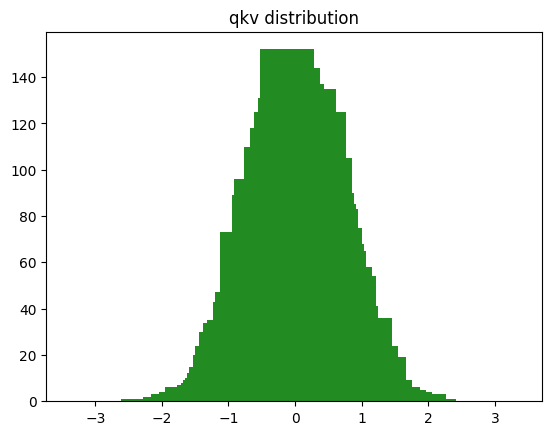

In [19]:
import matplotlib.pyplot as plt
y_value=torch.histc(qkv,bins=200,min=-3,max=3)
x_value=np.arange(-1,1,0.01)*3
plt.bar(x_value,y_value,align='center', color=['forestgreen'])
plt.title('qkv distribution')

In [20]:
num_heads= 8
head_dim=d_model//num_heads
qkv=qkv.reshape(batch_size,sequence_length,num_heads,3*head_dim)

In [21]:
qkv.shape

torch.Size([1, 4, 8, 192])

In [22]:
qkv = qkv.permute(0,2,1,3) #[batch_size,num_heads,sequence_length,3*head_dim]
qkv.shape

torch.Size([1, 8, 4, 192])

In [23]:
q, k ,v = qkv.chunk(3,dim=-1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

In [24]:
d_k=q.size()[-1]
scaled = torch.matmul(q,k.transpose(-2,-1))/math.sqrt(d_k)
scaled.shape

torch.Size([1, 8, 4, 4])

In [25]:
k.T.shape

torch.Size([64, 4, 8, 1])

In [26]:
y = torch.randn(2,3)
torch.transpose(y,0,1)

tensor([[ 0.2457, -0.1363],
        [-0.1727,  0.3949],
        [-0.0442, -0.3054]])

In [29]:
mask = torch.full(scaled.size(),float('-inf'))
mask = torch.triu(mask,diagonal=1)
mask[0][1],mask.shape

(tensor([[0., -inf, -inf, -inf],
         [0., 0., -inf, -inf],
         [0., 0., 0., -inf],
         [0., 0., 0., 0.]]),
 torch.Size([1, 8, 4, 4]))

In [30]:
(scaled+mask)[0][1]

tensor([[-0.1339,    -inf,    -inf,    -inf],
        [-0.1647, -0.2715,    -inf,    -inf],
        [ 0.2965,  0.0474, -0.0920,    -inf],
        [ 0.0973, -0.3625,  0.1329, -0.0759]], grad_fn=<SelectBackward0>)

In [31]:
scaled+=mask

In [32]:
attention = F.softmax(scaled,dim=-1)

In [33]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.4201, 0.5799, 0.0000, 0.0000],
        [0.2804, 0.3592, 0.3605, 0.0000],
        [0.2756, 0.1383, 0.2408, 0.3453]], grad_fn=<SelectBackward0>)

In [34]:
values = torch.matmul(attention,v)
values.shape

torch.Size([1, 8, 4, 64])

In [35]:
values = values.reshape(batch_size,sequence_length,num_heads*head_dim)
values.shape

torch.Size([1, 4, 512])

In [36]:
linear_layer = nn.Linear(d_model,d_model)
out = linear_layer(values)
out.shape

torch.Size([1, 4, 512])

In [44]:
import torch
import torch.nn as nn
import math
def scaled_dot_product(q,k,v,mask=None):
  d_k=q.size()[-1]
  scaled = torch.matmul(q,k.transpose(-1,-2))/math.sqrt(d_k)
  if mask is not None:
    scaled+=mask
  attention = F.softmax(scaled,dim=-1)
  values = torch.matmul(attention,v)
  return values,attention

class MultiheadAttention(nn.Module):
  def __init__(self,input_dim,d_model,num_heads):
    super().__init__()
    self.input_dim=input_dim
    self.d_model=d_model
    self.num_heads=num_heads
    self.head_dim=d_model//num_heads
    self.qkv_layer = nn.Linear(input_dim, 3*d_model)
    self.linear_layer = nn.Linear(d_model,d_model)
  def forward(self,x,mask=None):
    batch_size,sequence_length,input_dim=x.size()
    print(f'x.size(): {x.size()}')
    qkv=self.qkv_layer(x)
    print(f'qkv.size(): {qkv.size()}')
    qkv = qkv.reshape(batch_size,sequence_length,self.num_heads,3*self.head_dim)
    print(f'qkv.size(): {qkv.size()}')
    qkv=qkv.permute(0,2,1,3)
    print(f'qkv.size(): {qkv.size()}')
    q,k,v = qkv.chunk(3,dim=-1)
    values,attention = scaled_dot_product(q,k,v,mask)
    print(f'values.size(): {values.size()}')
    values = values.reshape(batch_size,sequence_length,self.num_heads*self.head_dim)
    out = self.linear_layer(values)
    print(f'out.size():{out.size()}')
    return out

In [45]:
input_dim =1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = torch.randn(batch_size,sequence_length,input_dim)

model = MultiheadAttention(input_dim,d_model,num_heads)
out = model.forward(x)

x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
values.size(): torch.Size([30, 8, 5, 64])
out.size():torch.Size([30, 5, 512])


# Postional Encoding

In [46]:
import torch
import torch.nn as nn

max_sequence_length = 10
d_model=6

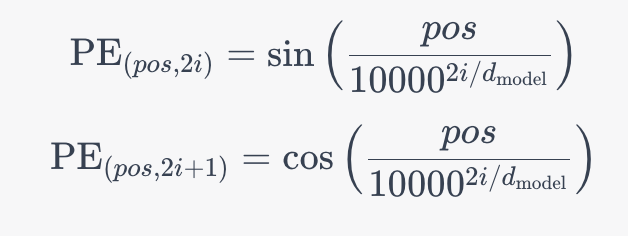

In [47]:
even_i = torch.arange(0,d_model,2).float()
even_i

tensor([0., 2., 4.])

In [49]:
even_denominator = torch.pow(10000,even_i/d_model)
even_denominator

tensor([  1.0000,  21.5443, 464.1590])

In [50]:
odd_i = torch.arange(1,d_model,2).float()
odd_denominator = torch.pow(10000,(odd_i-1)/d_model)
odd_denominator

tensor([  1.0000,  21.5443, 464.1590])

`even denominator` and `odd denominator` are the same! So we can just do one of these actions and call the resulting variable `denominator`

In [51]:
denominator = even_denominator

In [52]:
position = torch.arange(max_sequence_length,dtype=torch.float).reshape(max_sequence_length,1)

In [53]:
position

tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.],
        [9.]])

In [54]:
even_PE = torch.sin(position/denominator)
odd_PE = torch.cos(position/denominator)

In [55]:
even_PE

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.8415,  0.0464,  0.0022],
        [ 0.9093,  0.0927,  0.0043],
        [ 0.1411,  0.1388,  0.0065],
        [-0.7568,  0.1846,  0.0086],
        [-0.9589,  0.2300,  0.0108],
        [-0.2794,  0.2749,  0.0129],
        [ 0.6570,  0.3192,  0.0151],
        [ 0.9894,  0.3629,  0.0172],
        [ 0.4121,  0.4057,  0.0194]])

In [56]:
odd_PE

tensor([[ 1.0000,  1.0000,  1.0000],
        [ 0.5403,  0.9989,  1.0000],
        [-0.4161,  0.9957,  1.0000],
        [-0.9900,  0.9903,  1.0000],
        [-0.6536,  0.9828,  1.0000],
        [ 0.2837,  0.9732,  0.9999],
        [ 0.9602,  0.9615,  0.9999],
        [ 0.7539,  0.9477,  0.9999],
        [-0.1455,  0.9318,  0.9999],
        [-0.9111,  0.9140,  0.9998]])

In [57]:
stacked = torch.stack([even_PE,odd_PE],dim=2)
stacked.shape

torch.Size([10, 3, 2])

In [58]:
PE=torch.flatten(stacked,start_dim=1,end_dim=2)
PE

tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0464,  0.9989,  0.0022,  1.0000],
        [ 0.9093, -0.4161,  0.0927,  0.9957,  0.0043,  1.0000],
        [ 0.1411, -0.9900,  0.1388,  0.9903,  0.0065,  1.0000],
        [-0.7568, -0.6536,  0.1846,  0.9828,  0.0086,  1.0000],
        [-0.9589,  0.2837,  0.2300,  0.9732,  0.0108,  0.9999],
        [-0.2794,  0.9602,  0.2749,  0.9615,  0.0129,  0.9999],
        [ 0.6570,  0.7539,  0.3192,  0.9477,  0.0151,  0.9999],
        [ 0.9894, -0.1455,  0.3629,  0.9318,  0.0172,  0.9999],
        [ 0.4121, -0.9111,  0.4057,  0.9140,  0.0194,  0.9998]])

In [59]:
import torch
import torch.nn as nn

class PositonalEncoding(nn.Module):
  def __init__(self,d_model,max_sequence_length):
    super().__init__()
    self.max_sequence_length=max_sequence_length
    self.d_model = d_model

  def forward(self):
    even_i = torch.arange(0,self.d_model,2).float()
    denominator = torch.pow(10000,even_i/self.d_model)
    position = torch.arange(self.max_sequence_length).reshape(self.max_sequence_length,1)
    even_PE = torch.sin(position/denominator)
    odd_PE = torch.cos(position/denominator)
    stacked = torch.stack([even_PE,odd_PE],dim=2)
    PE = torch.flatten(stacked,start_dim=1,end_dim=2)
    return PE


In [60]:
pe=PositonalEncoding(d_model=6,max_sequence_length=10)
pe.forward()

tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0464,  0.9989,  0.0022,  1.0000],
        [ 0.9093, -0.4161,  0.0927,  0.9957,  0.0043,  1.0000],
        [ 0.1411, -0.9900,  0.1388,  0.9903,  0.0065,  1.0000],
        [-0.7568, -0.6536,  0.1846,  0.9828,  0.0086,  1.0000],
        [-0.9589,  0.2837,  0.2300,  0.9732,  0.0108,  0.9999],
        [-0.2794,  0.9602,  0.2749,  0.9615,  0.0129,  0.9999],
        [ 0.6570,  0.7539,  0.3192,  0.9477,  0.0151,  0.9999],
        [ 0.9894, -0.1455,  0.3629,  0.9318,  0.0172,  0.9999],
        [ 0.4121, -0.9111,  0.4057,  0.9140,  0.0194,  0.9998]])

#layer normaliation

In [61]:
import torch
from torch import nn

In [62]:
inputs=torch.tensor([[[0.2,0.1,0.3],[0.5,0.1,0.1]]])
B, S, E =inputs.size()
inputs = inputs.reshape(S,B,E)
inputs.size()

torch.Size([2, 1, 3])

In [64]:
parameter_shape = inputs.size()[-2:]
gamma = nn.Parameter(torch.ones(parameter_shape))
beta = nn.Parameter(torch.ones(parameter_shape))


In [65]:
gamma.size(),beta.size()

(torch.Size([1, 3]), torch.Size([1, 3]))

In [66]:
dims =[-(i+1) for i in range(len(parameter_shape))]

In [67]:
dims

[-1, -2]

In [68]:
mean = inputs.mean(dim=dims,keepdim=True)
mean.size()

torch.Size([2, 1, 1])

In [69]:
var = ((inputs-mean)**2).mean(dim=dims,keepdim=True)
epslion=1e-5
std =(var+epslion).sqrt()
std.size()

torch.Size([2, 1, 1])

In [70]:
y=(inputs-mean)/std
y

tensor([[[ 0.0000, -1.2238,  1.2238]],

        [[ 1.4140, -0.7070, -0.7070]]])

In [71]:
out =  y*gamma + beta

In [72]:
out

tensor([[[ 1.0000, -0.2238,  2.2238]],

        [[ 2.4140,  0.2930,  0.2930]]], grad_fn=<AddBackward0>)

In [73]:
import torch
from torch import nn

class  LayerNormalization():
  def __init__(self,parameters_shape,epslion=1e-5):
    self.parameters_shape = parameters_shape
    self.epslion = epslion
    self.gamma = nn.Parameter(torch.ones(parameters_shape))
    self.beta = nn.Parameter(torch.zeros(parameters_shape))
  def forward(self,input):
    dims = [-(i+1) for i in range(len(self.parameters_shape))]
    mean = inputs.mean(dim=dims,keepdim=True)
    print(f"mean:{mean}")
    var = ((inputs-mean)**2).mean(dim=dims,keepdim=True)
    std =(var+self.epslion).sqrt()
    print(f"std:{std}")
    y=(inputs-mean)/std
    print(f"y:{y}")
    out =  y*self.gamma + self.beta
    print(f"out:{out}")
    return out